In [122]:
import os
import torch
from torchvision import datasets, transforms
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score
import vision_transformer as vits
import vision_transformer as vits
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from torchvision import transforms as pth_transforms

In [123]:

model = vits.__dict__['vit_small']()#pretrained=True)
#model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

checkpoint = torch.load('/Users/rohitpotdukhe/Documents/checkpoint0080.pth', map_location=torch.device('cpu'))

state_dict = checkpoint['teacher']

# remove `module.` prefix
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
# remove `backbone.` prefix induced by multicrop wrapper
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}

# Load the adjusted state dict into the model
model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])

In [124]:

'''# Define the transformations (this should be the same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Example resize, adjust to your needs
    transforms.ToTensor(),
    # Add the same normalization as used during training
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])'''

transform = pth_transforms.Compose([
        pth_transforms.Resize(256, interpolation=3),
        pth_transforms.CenterCrop(224),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

test_dataset_dir = '/Users/rohitpotdukhe/Documents/val'

labeled_dataset = datasets.ImageFolder(test_dataset_dir, transform=transform)
labeled_loader = torch.utils.data.DataLoader(labeled_dataset, batch_size=32, shuffle=True)

# Initialize a list to store predictions
all_predictions = []
# Iterate over test dataset using DataLoader
for images, _ in labeled_loader:
    # Forward pass through the model
    with torch.no_grad():
        model.eval()
        outputs = model(images)

    # Append the predictions to the list
    all_predictions.append(outputs.cpu().numpy())

# Combine predictions into a single NumPy array
all_predictions = np.concatenate(all_predictions, axis=0)

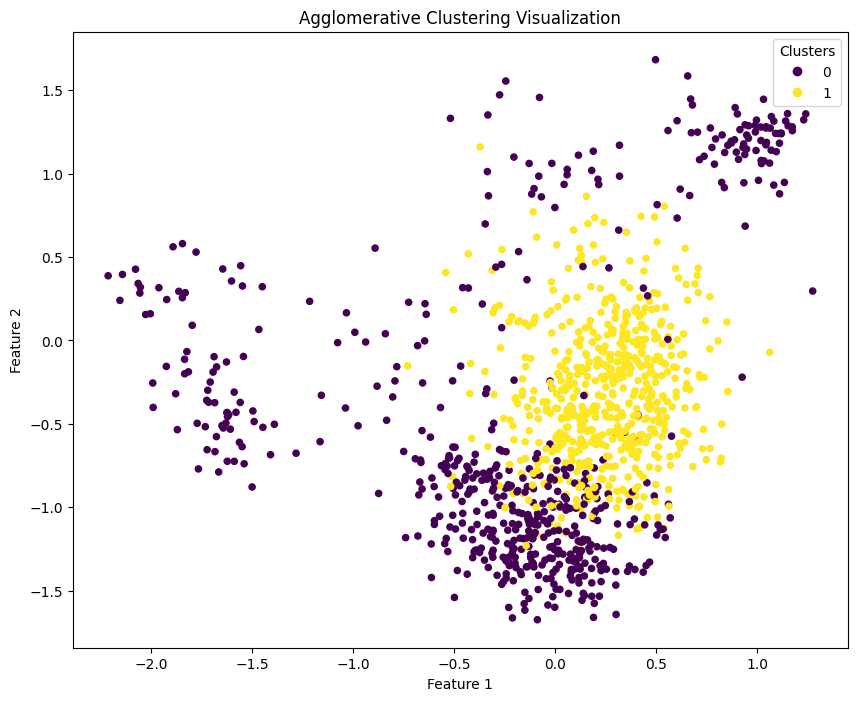

Accuracy: 0.4910333048676345


In [126]:

'''pca = PCA(n_components=2)
reduced_features = pca.fit_transform(all_predictions)'''

# Create an Agglomerative Clustering model
n_clusters = 2  # You need to specify the number of clusters
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)

# Fit the clustering model to your data
#cluster_labels = agg_clustering.fit_predict(reduced_features)
cluster_labels = agg_clustering.fit_predict(all_predictions)

# Visualize the clusters
plt.figure(figsize=(10, 8))

# Scatter plot of the cluster representations in 2D
#scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=20)
scatter = plt.scatter(all_predictions[:, 0], all_predictions[:, 1], c=cluster_labels, cmap='viridis', s=20)

# Customize the plot
plt.title('Agglomerative Clustering Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()

# Assuming you have ground truth labels for your test dataset
# Replace 'true_labels' with the actual ground truth labels
true_labels = labeled_dataset.targets

accuracy = accuracy_score(true_labels, cluster_labels)

print(f"Accuracy: {accuracy}")

In [70]:
print(true_labels)
print(len(true_labels))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [87]:
print(cluster_labels)



[1 1 1 ... 1 1 0]


In [73]:
print(labeled_dataset.class_to_idx)

{'FC': 0, 'NG': 1}


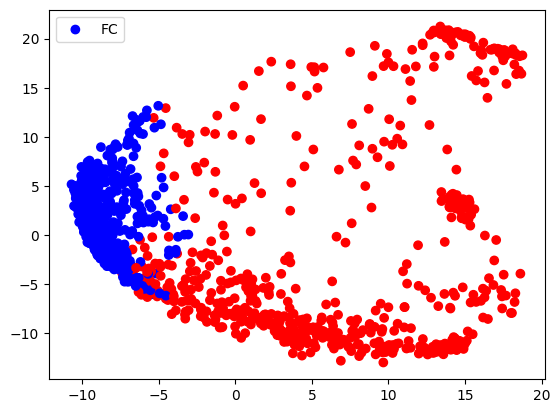

In [91]:
import matplotlib.pyplot as plt

# Assuming reduced_features is a 2D array
x = reduced_features[:, 0]
y = reduced_features[:, 1]

'''x = all_predictions[:, 0]
y = all_predictions[:, 1]'''

# Create a color map for the original labels
colors = ['red' if label == 0 else 'blue' for label in cluster_labels]

plt.scatter(x, y, c=colors)

# Add a legend
plt.legend(['FC', 'NG'])

plt.show()

In [105]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in labeled_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy}%')


tensor([235, 112, 262, 347, 310, 210,  50, 310,  52, 310, 347, 235,  50,  50,
        132, 262,  52, 369,  50,  64,  50, 310, 235, 370, 210, 310, 369,  64,
         50, 378, 310,  64])
tensor([ 50, 278,  50, 278,  64,  50,  50, 210,  57, 112, 347, 235, 278, 230,
         50,  50,  91,  50,  94,  50, 262,  52, 210, 378, 278,  50, 262,  94,
         50, 204,  50, 341])
tensor([369, 310,  91,  50, 132,  50,  52, 132, 210,  50,  52,  50, 369, 210,
         64, 262,  50,  50,  50, 369, 201,  50, 132,  52, 132, 310,  64, 103,
        369,  50, 278,  52])
tensor([ 79,  50, 262, 132, 347,  50, 369, 132, 278, 112,  50,  50, 235,  64,
         64, 347,  64,  50,  64, 189,  50, 369,  50, 278,  50,  52, 260,  52,
        210,  50, 310, 347])
tensor([278, 369,  64,  79,  50,  50,  82, 310,  64, 347,  50,  50, 262, 278,
        310, 341, 310, 210,  50,  50, 310,  64, 262, 347, 112, 310, 235, 369,
        347, 310, 347, 262])
tensor([ 52,  50, 278, 369,  50,  64,  50,  64,  50, 278, 235, 278,  50,  5